In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

EXTRACTING DATE FEATURES

Üretim t-1 column needs to be shifted once since **we need to report predictions at least 1 hour beforehands**

Part01234 columns should be shifted twice as we can access only time = t-2 due to the same reason

In [ ]:
df = pd.read_excel('powerplant_data.xlsx', index_col=0)
df.columns = ['time','forecastT-75','target','part0','part1','part2','part3','part4','t-1']
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour 
df['week'] = df['time'].dt.week
df['t-2'] = df['t-1'].shift()
part_cols = [col for col in df.columns if 'part' in col.lower()]
for i in part_cols:
  df[i] = df[i].shift(2) 
df = df.drop('t-1',1).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
df

,time,forecastT-75,target,part0,part1,part2,part3,part4,day,month,hour,week,t-2
2,2020-01-01 02:00:00,0.635,0.325,0.045376,0.026701,0.021143,0.036322,0.020318,1,1,2,1,0.000
3,2020-01-01 03:00:00,0.515,0.000,0.041271,0.016510,0.034583,0.028692,0.038147,1,1,3,1,0.000
4,2020-01-01 04:00:00,0.450,0.000,0.039892,0.520764,0.554837,0.651030,0.138745,1,1,4,1,0.325
5,2020-01-01 05:00:00,0.455,0.000,0.039533,0.040981,0.028857,0.017618,0.030898,1,1,5,1,0.000
6,2020-01-01 06:00:00,0.600,0.000,0.030361,0.035847,0.024929,0.035401,0.036201,1,1,6,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8771,2020-12-31 20:00:00,34.065,36.495,31.935007,35.100559,37.364333,37.236592,36.905091,31,12,20,53,35.885
8772,2020-12-31 21:00:00,34.250,37.005,36.488404,35.970513,34.776159,34.327873,35.997701,31,12,21,53,35.555
8773,2020-12-31 22:00:00,33.080,36.935,34.518909,35.868938,36.682375,37.195969,37.336583,31,12,22,53,36.495
8774,2020-12-31 23:00:00,28.855,29.880,37.030349,37.158400,37.235866,36.988668,36.867310,31,12,23,53,37.005


SPLITTING

In [ ]:
train = df[df['time']<'2020-10-01 00:00:00']
val = df[df['time']>='2020-10-01 00:00:00']

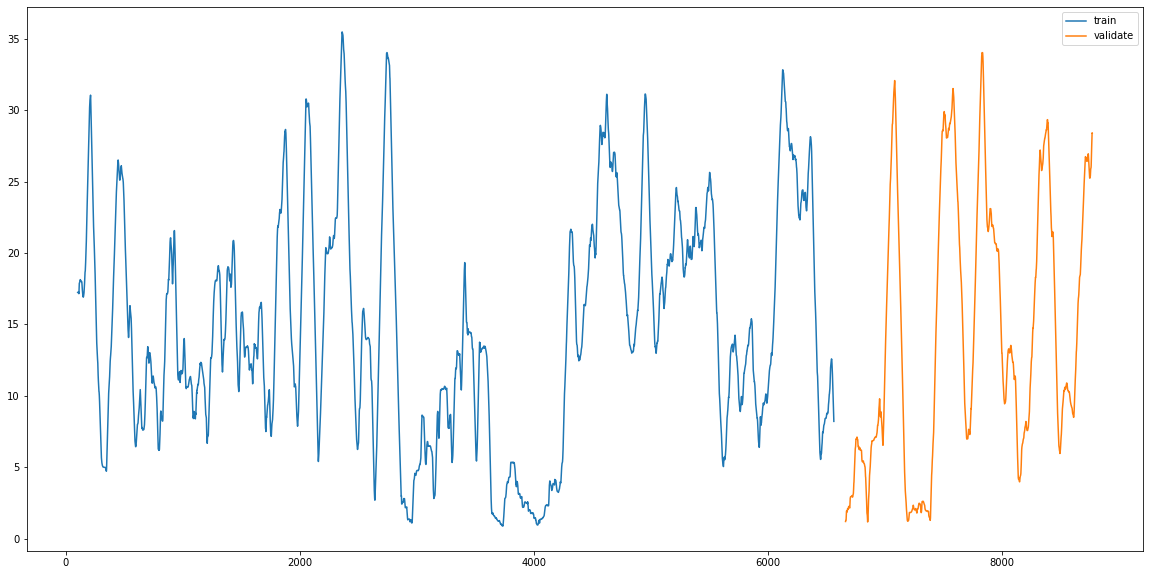

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['target'].rolling(window=100).mean(), label='train')
plt.plot(val['target'].rolling(window=100).mean(), label='validate')
plt.legend()

# Splitting the last week of train set to inspect model success

Trying to predict the last week of the training set

In [ ]:
X_train = train.head(-7*24).drop(['target','time'],1).values
y_train = train.head(-7*24)['target'].values
X_test = train.tail(7*24).drop(['target','time'],1).values
y_test = train.tail(7*24)['target'].values

In [ ]:
lr = LinearRegression()
sgd = SGDRegressor()
h = HuberRegressor(max_iter=1000)
ran = RANSACRegressor()
svr = svm.SVR()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
xg = XGBRegressor(verbosity=0)
las = Lasso()
rid = Ridge()
gb = GradientBoostingRegressor(random_state=1, verbose=0)
mlpr = MLPRegressor(hidden_layer_sizes=[40,40,40], learning_rate='adaptive', early_stopping=True, max_iter=1000, random_state=42)
bag = BaggingRegressor(base_estimator=lr)
knr = KNeighborsRegressor(n_neighbors=3)

In [ ]:
d = {}
for model in [lr,las,rid,xg,gb,knr,svr,rf,h,mlpr]:
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  pred = np.clip(pred,0,np.inf)
  d[str(model).split('Reg')[0]+'prediction'] = pred
  d = pd.DataFrame(d)
  print(str(model).split('(')[0],np.round(np.sqrt(mean_squared_error(y_test,pred)),4))

LinearRegression 4.2178
Lasso 4.1191
Ridge 4.2179
XGBRegressor 4.3009
GradientBoostingRegressor 4.2638
KNeighborsRegressor 5.2552
SVR 4.5841
RandomForestRegressor 4.0817
HuberRegressor 4.3366
MLPRegressor 4.33


RF Regressor will be used

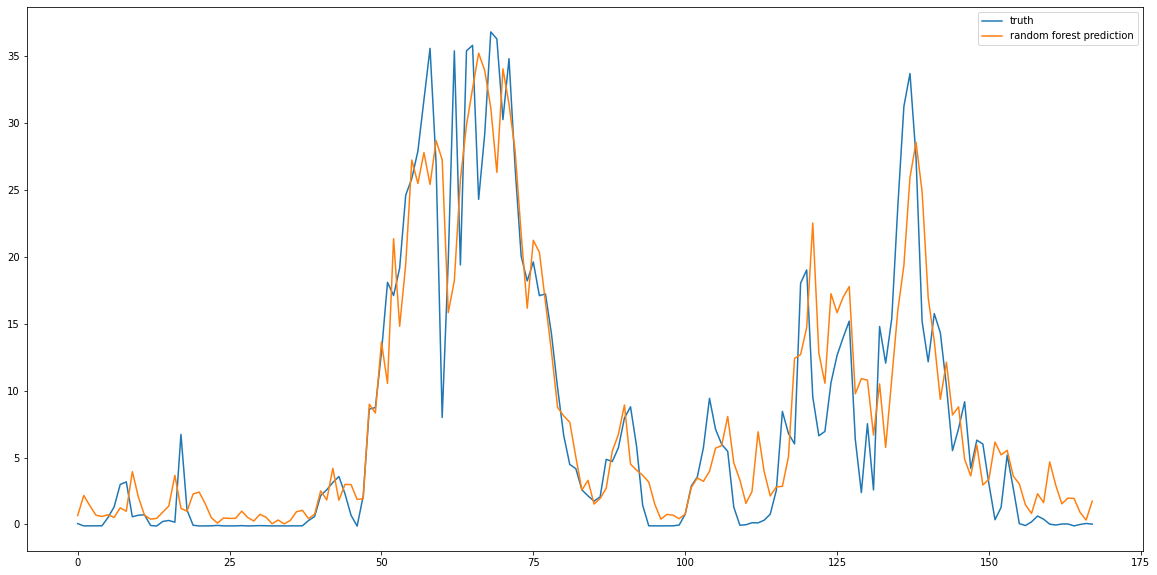

In [ ]:
rf.fit(X_train,y_train)
pred = rf.predict(X_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, label='truth')
plt.plot(pred, label='random forest prediction')
plt.legend()

HYPERPARAMETER OPTIMIZATION WITH TIME SERIES SPLIT CROSS VALIDATION

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(s1,s2):
  return np.sqrt(mean_squared_error(s1,s2))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
my_func = make_scorer(rmse, greater_is_better=False)
model = rf
tscv = TimeSeriesSplit(n_splits=3)
gsearch = RandomizedSearchCV(estimator=model, cv=tscv,param_distributions=random_grid, scoring=my_func)
gsearch.fit(train.drop(['time','target'],1).values,train['target'].values.ravel())

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0...
                   iid='deprecate

In [ ]:
gsearch.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1550}

In [ ]:
gsearch.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1550, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Fitting on train data, predicting 1 week ahead, appending and keep predicting incrementally

WITHOUT SAMPLE WEIGHTS

In [ ]:
def round(x):
  return np.round(x,4)

In [ ]:
#Random Forest
model = gsearch.best_estimator_
#creating weekly data 7x24 = 168 rows each
weeklyval = val.drop('time',1).head(-25).values.reshape((-1,168,val.shape[1]-1))
#initializing X and y
merged_target = train['target'].values
merged_data = train.drop(['time','target'],1).values
preds = []
targets = []
t75s = []
#incrementally fitting and adding for 13 weeks
for i in range(13):
  #target = weeklyval[i][:,1]
  data_to_predict = np.delete(weeklyval[i],1,1)
  t75 = weeklyval[i][:,0]
  cevap = weeklyval[i][:,1]
  model.fit(merged_data,merged_target)
  weekly_pred = model.predict(data_to_predict)
  weekly_pred = np.clip(weekly_pred,0,np.inf)
  merged_target = np.concatenate((merged_target,weekly_pred))
  merged_data = np.vstack((merged_data,np.delete(weeklyval[i],1,1)))
  preds.append(weekly_pred)
  targets.append(cevap)
  t75s.append(t75)
  print('rmse on week',i+1,'=',round(rmse(weekly_pred,cevap[-len(weekly_pred):])),
        ',forecast t-75 on week',i+1,'=',round(rmse(weeklyval[i][:,0],weeklyval[i][:,1])),
        ',overall rmse on week',i+1,'=',round(rmse(preds,targets)))
  #print('fitting first',i+1,'weeks with overall rmse',np.round(rmse(merged_target,df['target'].head(len(merged_target))),4))
#for the last day
data_to_predict = df.drop(['time','target'],1).tail(25).values
model.fit(merged_data,merged_target)
weekly_pred = model.predict(data_to_predict)
weekly_pred = np.clip(weekly_pred,0,np.inf)
merged_target = np.concatenate((merged_target,weekly_pred))
merged_data = np.vstack((merged_data,np.delete(weeklyval[i],1,1)))
print('adding last leftover day with final rmse',round(rmse(preds,targets)),'vs. t-75 forecast',round(rmse(t75s,targets)))

rmse on week 1 = 3.7975 ,forecast t-75 on week 1 = 3.6767 ,overall rmse on week 1 = 3.7975
rmse on week 2 = 6.1772 ,forecast t-75 on week 2 = 5.8493 ,overall rmse on week 2 = 5.1273
rmse on week 3 = 5.7495 ,forecast t-75 on week 3 = 5.969 ,overall rmse on week 3 = 5.3428
rmse on week 4 = 2.2464 ,forecast t-75 on week 4 = 2.4497 ,overall rmse on week 4 = 4.7614
rmse on week 5 = 3.6055 ,forecast t-75 on week 5 = 3.6375 ,overall rmse on week 5 = 4.5537
rmse on week 6 = 4.701 ,forecast t-75 on week 6 = 4.7829 ,overall rmse on week 6 = 4.5786
rmse on week 7 = 4.234 ,forecast t-75 on week 7 = 4.7208 ,overall rmse on week 7 = 4.531
rmse on week 8 = 3.2229 ,forecast t-75 on week 8 = 2.8246 ,overall rmse on week 8 = 4.3888
rmse on week 9 = 5.2928 ,forecast t-75 on week 9 = 5.382 ,overall rmse on week 9 = 4.4982
rmse on week 10 = 4.1251 ,forecast t-75 on week 10 = 4.5601 ,overall rmse on week 10 = 4.4623
rmse on week 11 = 5.6646 ,forecast t-75 on week 11 = 5.8799 ,overall rmse on week 11 = 4.584

Overall RMSE increases as the prediction interval increases which is expected as we are predicting on predictions, piling up the biases at each step

# Locating Corrupt Data and Lowering Corresponding Sample Weights Proportionally

In [ ]:
parts = df.iloc[:,3:8]
manual_entry = {}
for i in range(5):
  manual_entry[str(i)] = np.where([parts.iloc[:,i]*1000%10 == 0])[1]
repeating = {}
for i in range(5):
  repeating[str(i)] = np.where([(parts.iloc[:,i].diff()==0)&(parts.iloc[:,i]!=0)])[1]
man = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in manual_entry.items()]))
rep = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in repeating.items()]))

Here I count how many of the columns of an instance is corrupt to sum them and lower the weight proportionally, So an index with repeating and/or two digits will impact the model less based on Weight = 1/(total corruption in the row+1).

In [ ]:
corrupt_data = pd.DataFrame(pd.Series(pd.concat([man,rep],1).values.ravel()).value_counts().reset_index())
corrupt_data.columns = ['index','weight']
corrupt_data['weight'] = 1/(corrupt_data['weight'] + 1)   
sample_weights = np.ones(shape=merged_target.shape)
sample_weights[corrupt_data['index'].astype(int)] = corrupt_data['weight']

In [ ]:
corrupt_data

,index,weight
0,2794.0,0.090909
1,2788.0,0.090909
2,2774.0,0.090909
3,2793.0,0.090909
4,2778.0,0.090909
...,...,...
452,4803.0,0.500000
453,5634.0,0.500000
454,2738.0,0.500000
455,2882.0,0.500000


WITH SAMPLE WEIGHTS

In [ ]:
#Random Forest
model = gsearch.best_estimator_
#creating weekly data 7x24 = 168 rows each
weeklyval = val.drop('time',1).head(-25).values.reshape((-1,168,val.shape[1]-1))
#initializing X and y
merged_target = train['target'].values
merged_data = train.drop(['time','target'],1).values
preds = []
targets = []
t75s = []
#incrementally fitting and adding for 13 weeks
for i in range(13):
  #target = weeklyval[i][:,1]
  data_to_predict = np.delete(weeklyval[i],1,1)
  t75 = weeklyval[i][:,0]
  cevap = weeklyval[i][:,1]
  model.fit(merged_data,merged_target,sample_weight=sample_weights[:len(merged_target)])
  weekly_pred = model.predict(data_to_predict)
  weekly_pred = np.clip(weekly_pred,0,np.inf)
  merged_target = np.concatenate((merged_target,weekly_pred))
  merged_data = np.vstack((merged_data,np.delete(weeklyval[i],1,1)))
  preds.append(weekly_pred)
  targets.append(cevap)
  t75s.append(t75)
  print('rmse on week',i+1,'=',round(rmse(weekly_pred,cevap[-len(weekly_pred):])),
        ',forecast t-75 on week',i+1,'=',round(rmse(weeklyval[i][:,0],weeklyval[i][:,1])),
        ',overall rmse on week',i+1,'=',round(rmse(preds,targets)))
  #print('fitting first',i+1,'weeks with overall rmse',np.round(rmse(merged_target,df['target'].head(len(merged_target))),4))
#for the last day
data_to_predict = df.drop(['time','target'],1).tail(25).values
model.fit(merged_data,merged_target)
weekly_pred = model.predict(data_to_predict)
weekly_pred = np.clip(weekly_pred,0,np.inf)
merged_target = np.concatenate((merged_target,weekly_pred))
merged_data = np.vstack((merged_data,np.delete(weeklyval[i],1,1)))
print('adding last leftover day with final rmse',round(rmse(preds,targets)),'vs. t-75 forecast',round(rmse(t75s,targets)))

rmse on week 1 = 3.7943 ,forecast t-75 on week 1 = 3.6767 ,overall rmse on week 1 = 3.7943
rmse on week 2 = 6.1821 ,forecast t-75 on week 2 = 5.8493 ,overall rmse on week 2 = 5.1291
rmse on week 3 = 5.7571 ,forecast t-75 on week 3 = 5.969 ,overall rmse on week 3 = 5.3466
rmse on week 4 = 2.2656 ,forecast t-75 on week 4 = 2.4497 ,overall rmse on week 4 = 4.7669
rmse on week 5 = 3.6014 ,forecast t-75 on week 5 = 3.6375 ,overall rmse on week 5 = 4.5577
rmse on week 6 = 4.721 ,forecast t-75 on week 6 = 4.7829 ,overall rmse on week 6 = 4.5853
rmse on week 7 = 4.235 ,forecast t-75 on week 7 = 4.7208 ,overall rmse on week 7 = 4.5369
rmse on week 8 = 3.2148 ,forecast t-75 on week 8 = 2.8246 ,overall rmse on week 8 = 4.3935
rmse on week 9 = 5.2982 ,forecast t-75 on week 9 = 5.382 ,overall rmse on week 9 = 4.503
rmse on week 10 = 4.0986 ,forecast t-75 on week 10 = 4.5601 ,overall rmse on week 10 = 4.4642
rmse on week 11 = 5.6865 ,forecast t-75 on week 11 = 5.8799 ,overall rmse on week 11 = 4.588

Adding weights worsened the results which is understandable considering random forest is prone to overfitting. Sample weights improved linear and gradient boosting models.

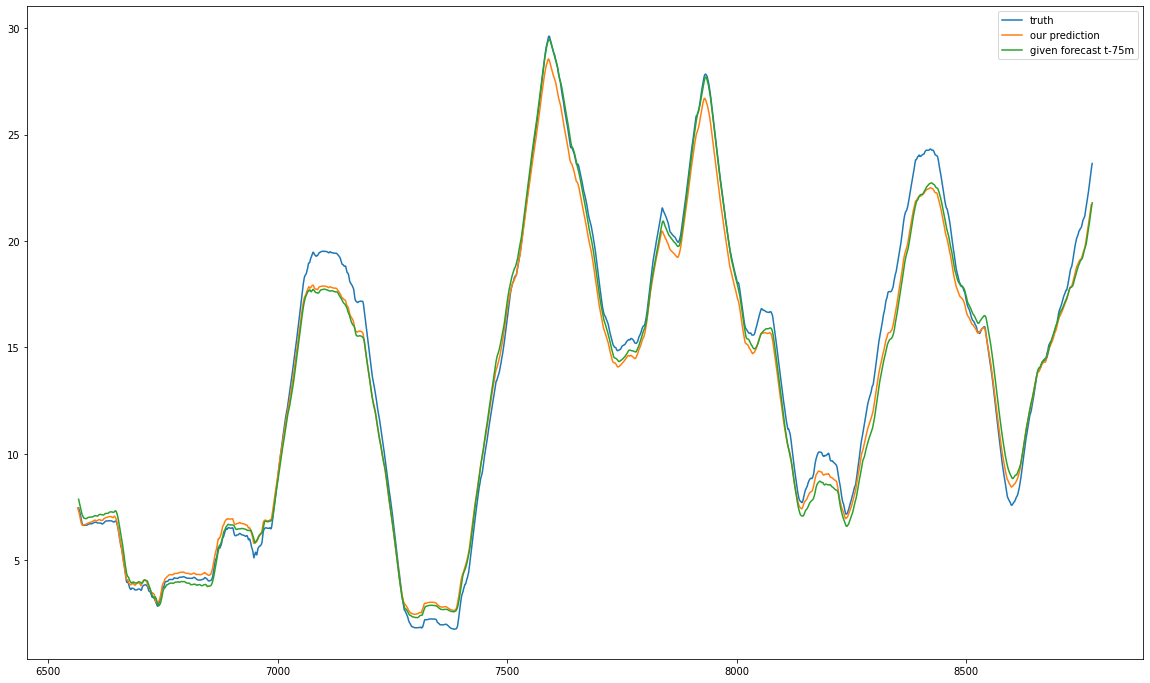

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(df['target'].rolling(window=200).mean().tail(2210), label='truth')
plt.plot(pd.Series(merged_target).rolling(window=200).mean().tail(2210), label='our prediction')
plt.plot(df['forecastT-75'].rolling(window=200).mean().tail(2210),label='given forecast t-75m')
plt.legend()

# Conclusion:
Linear models performed better overall, but to demonstrate a standard parameter search Random Forest model was chosen. Sample weights based on the corrupted data(repeated and manually entered values) improved linear models but slightly worsened rf. One can add more features like exponential weighted moving average, moving average, lag features etc. in order to improve further on the RMSE score. This notebook is just to demonstrate the basic pipeline for a incremental timeseries regression problem.

Quick demonstration of huber regressor which is an outlier-resistant linear regression model.

In [ ]:
#Huber Regressor
model = h
#creating weekly data 7x24 = 168 rows each
weeklyval = val.drop('time',1).head(-25).values.reshape((-1,168,val.shape[1]-1))
#initializing X and y
merged_target = train['target'].values
merged_data = train.drop(['time','target'],1).values
preds = []
targets = []
t75s = []
#incrementally fitting and adding for 13 weeks
for i in range(13):
  #target = weeklyval[i][:,1]
  data_to_predict = np.delete(weeklyval[i],1,1)
  t75 = weeklyval[i][:,0]
  cevap = weeklyval[i][:,1]
  model.fit(merged_data,merged_target,sample_weight=sample_weights[:len(merged_target)])
  weekly_pred = model.predict(data_to_predict)
  weekly_pred = np.clip(weekly_pred,0,np.inf)
  merged_target = np.concatenate((merged_target,weekly_pred))
  merged_data = np.vstack((merged_data,np.delete(weeklyval[i],1,1)))
  preds.append(weekly_pred)
  targets.append(cevap)
  t75s.append(t75)
  print('rmse on week',i+1,'=',round(rmse(weekly_pred,cevap[-len(weekly_pred):])),
        ',forecast t-75 on week',i+1,'=',round(rmse(weeklyval[i][:,0],weeklyval[i][:,1])),
        ',overall rmse on week',i+1,'=',round(rmse(preds,targets)))
  #print('fitting first',i+1,'weeks with overall rmse',np.round(rmse(merged_target,df['target'].head(len(merged_target))),4))
#for the last day
data_to_predict = df.drop(['time','target'],1).tail(25).values
model.fit(merged_data,merged_target)
weekly_pred = model.predict(data_to_predict)
weekly_pred = np.clip(weekly_pred,0,np.inf)
merged_target = np.concatenate((merged_target,weekly_pred))
merged_data = np.vstack((merged_data,np.delete(weeklyval[i],1,1)))
print('adding last leftover day with final rmse',round(rmse(preds,targets)),'vs. t-75 forecast',round(rmse(t75s,targets)))

rmse on week 1 = 3.5782 ,forecast t-75 on week 1 = 3.6767 ,overall rmse on week 1 = 3.5782
rmse on week 2 = 6.2819 ,forecast t-75 on week 2 = 5.8493 ,overall rmse on week 2 = 5.112
rmse on week 3 = 5.3786 ,forecast t-75 on week 3 = 5.969 ,overall rmse on week 3 = 5.2024
rmse on week 4 = 2.0264 ,forecast t-75 on week 4 = 2.4497 ,overall rmse on week 4 = 4.618
rmse on week 5 = 3.3741 ,forecast t-75 on week 5 = 3.6375 ,overall rmse on week 5 = 4.3974
rmse on week 6 = 4.5524 ,forecast t-75 on week 6 = 4.7829 ,overall rmse on week 6 = 4.4236
rmse on week 7 = 4.1783 ,forecast t-75 on week 7 = 4.7208 ,overall rmse on week 7 = 4.3894
rmse on week 8 = 2.9531 ,forecast t-75 on week 8 = 2.8246 ,overall rmse on week 8 = 4.2366
rmse on week 9 = 4.7894 ,forecast t-75 on week 9 = 5.382 ,overall rmse on week 9 = 4.3015
rmse on week 10 = 3.8735 ,forecast t-75 on week 10 = 4.5601 ,overall rmse on week 10 = 4.2607
rmse on week 11 = 5.3934 ,forecast t-75 on week 11 = 5.8799 ,overall rmse on week 11 = 4.37

Improved rmse from 4.62 of random forest to 4.37

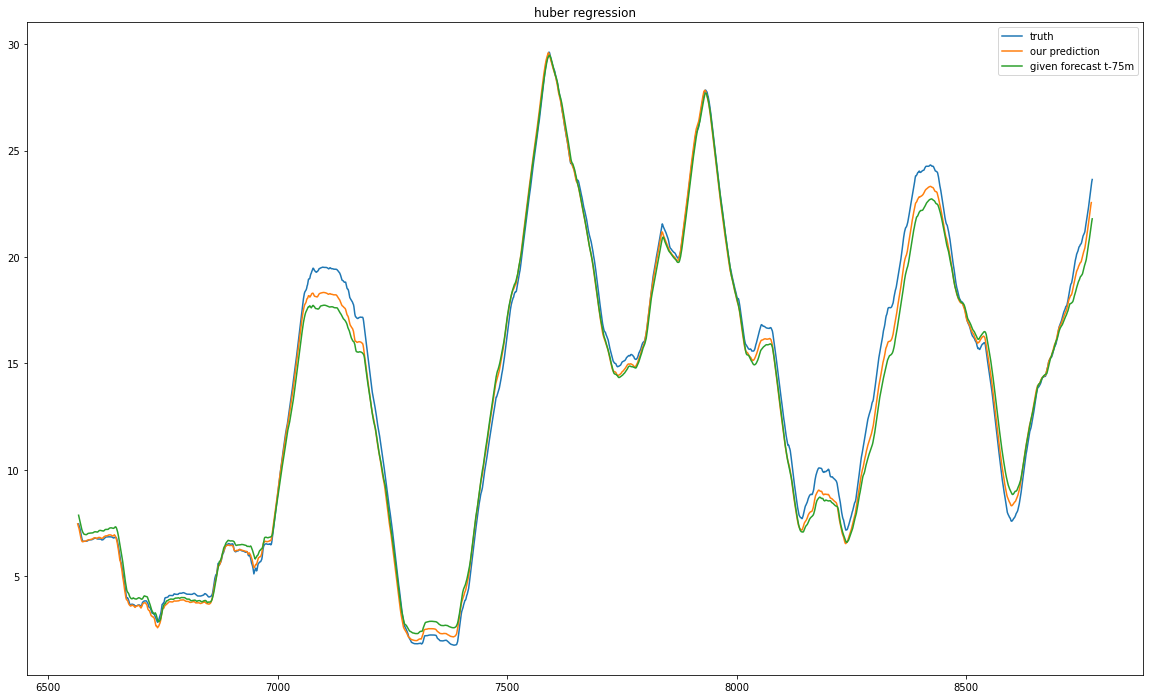

In [ ]:
plt.figure(figsize=(20,12))
plt.title('huber regression')
plt.plot(df['target'].rolling(window=200).mean().tail(2210), label='truth')
plt.plot(pd.Series(merged_target).rolling(window=200).mean().tail(2210), label='our prediction')
plt.plot(df['forecastT-75'].rolling(window=200).mean().tail(2210),label='given forecast t-75m')
plt.legend()

In [ ]:
%%shell
jupyter nbconvert --to html /content/SmartPulseTask2.ipynb

[NbConvertApp] Converting notebook /content/SmartPulseTask2.ipynb to html
[NbConvertApp] Writing 869313 bytes to /content/SmartPulseTask2.html
